## __Goal__
* see how long it takes to train mxnet on laptop

In [50]:
#****************************************************************************
##   import a few libraries, system checks
#****************************************************************************
import numpy as np
import pandas as pnd
from time import time
import random
random_seed = 3
random.seed(random_seed)

import mxnet as mx
from mxnet import nd, autograd, gluon
import os
os.environ['MXNET_CPU_WORKER_NTHREADS']='3'
import sys
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pnd.__version__)
print("MXNet: ", mx.__version__)
print("numpy, pandas, mxnet, time and random libraries imported...")

OS:  linux
Python:  3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
Numpy:  1.13.1
Pandas:  0.21.0
MXNet:  0.12.1
numpy, pandas, mxnet, time and random libraries imported...


In [51]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import re
from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
import logging
# logging to stdout
logging.getLogger().setLevel(logging.DEBUG)


In [52]:
#****************************************************************************
##       useful functions
#****************************************************************************
data_loc = "./data/"   # replace when running in kernel
def import_data():
    t_start = time()
    tr = pnd.read_table(data_loc +"train.tsv")
    te = pnd.read_table(data_loc +"test.tsv")
    print("Data imported...")
    print("train shape:", tr.shape)
    print("test shape:", te.shape)
    print("import_data() exution time:", time() - t_start, "seconds")
    return (tr, te)

def expand_category(df_data):
    ### --- extract sub categories
    t_start = time()
    tmp_df = df_data
    ## split "category_name"
    tmp_cat_df = tmp_df.category_name.str.split("/", expand=True)
    cat_levels = ["cat_name", "cat_name2", "cat_name3", "cat_name4", "cat_name5"]
    tmp_cat_df.columns = cat_levels
    tmp_df = tmp_df.assign(cat_name = tmp_cat_df.cat_name)
    tmp_df = tmp_df.assign(cat_name2 = tmp_cat_df.cat_name2)
    tmp_df = tmp_df.assign(cat_name3 = tmp_cat_df.cat_name3)
    tmp_df = tmp_df.assign(cat_name4 = tmp_cat_df.cat_name4)
    tmp_df = tmp_df.assign(cat_name5 = tmp_cat_df.cat_name5)
    print("expand_category() execution time:", time() - t_start, "seconds")
    return tmp_df

def missing_indicators(df_data):
    ### --- create missing indicator variables
    t_start = time()
    tmp_df = df_data
    tmp_df = tmp_df.assign(brand_na = tmp_df.brand_name.isnull().astype(int))
    tmp_df = tmp_df.assign(category_na = tmp_df.category_name.isnull().astype(int))
    tmp_df = tmp_df.assign(description_na = tmp_df.item_description.isnull().astype(int))
    tmp_df = tmp_df.assign(cat_name_na = tmp_df.cat_name.isnull().astype(int))
    tmp_df = tmp_df.assign(cat_name2_na = tmp_df.cat_name2.isnull().astype(int))
    tmp_df = tmp_df.assign(cat_name3_na = tmp_df.cat_name3.isnull().astype(int))
    tmp_df = tmp_df.assign(cat_name4_na = tmp_df.cat_name4.isnull().astype(int))
    tmp_df = tmp_df.assign(cat_name5_na = tmp_df.cat_name5.isnull().astype(int))
    print("executing missing indicators took:", time() - t_start, "seconds")
    return tmp_df

def replace_missing(df_data):
    ### --- replace missing values
    t_start = time()
    tmp_df = df_data
    str_na="NA"
    tmp_df.category_name = tmp_df.category_name.fillna(value=str_na)
    tmp_df.brand_name = tmp_df.brand_name.fillna(value=str_na)
    tmp_df.item_description = tmp_df.item_description.fillna(value=str_na)
    tmp_df.cat_name = tmp_df.cat_name.fillna(value=str_na)
    tmp_df.cat_name2 = tmp_df.cat_name2.fillna(value=str_na)
    tmp_df.cat_name3 = tmp_df.cat_name3.fillna(value=str_na)
    tmp_df.cat_name4 = tmp_df.cat_name4.fillna(value=str_na)
    tmp_df.cat_name5 = tmp_df.cat_name5.fillna(value=str_na)
    print("replacing missing values took:", time() - t_start, "seconds")
    return tmp_df

### --- add meta variables
def get_descr_meta(dataf):
    t_meta = time()
    tmp_df = dataf
    tmp_series = tmp_df.item_description   # extract from 'item_description'  
    tmp_df = tmp_df.assign(desc_len = tmp_series.str.len())
    tmp_df = tmp_df.assign(desc_tot_excla = tmp_series.str.count("[!]"))
    tmp_df = tmp_df.assign(desc_tot_qmark = tmp_series.str.count("[?]"))
    tmp_df = tmp_df.assign(desc_tot_alnum = tmp_series.str.count("\\w"))
    tmp_df = tmp_df.assign(desc_tot_upper = tmp_series.str.count("[A-Z]"))
    tmp_df = tmp_df.assign(desc_tot_lower = tmp_series.str.count("[a-z]"))
    tmp_df = tmp_df.assign(desc_tot_digit = tmp_series.str.count("[0-9]"))
    tmp_df = tmp_df.assign(desc_tot_space = tmp_series.str.count("[' ']"))
    tmp_df = tmp_df.assign(desc_tot_hyphen = tmp_series.str.count("[-]"))
    tmp_df = tmp_df.assign(desc_tot_word = tmp_series.str.count("[A-Za-z]{3,}"))
    tmp_df = tmp_df.assign(desc_tot_rm = tmp_series.str.count("'[rm]'"))
    print("meta features from description took:", time() - t_meta, "seconds")
    return tmp_df

def get_name_meta(dataf):
    t_meta = time()
    tmp_df = dataf
    tmp_series = tmp_df.name   # extract from 'name'    
    tmp_df = tmp_df.assign(name_len = tmp_series.str.len())
    tmp_df = tmp_df.assign(name_tot_excla = tmp_series.str.count("[!]"))
    tmp_df = tmp_df.assign(name_tot_qmark = tmp_series.str.count("[?]"))
    tmp_df = tmp_df.assign(name_tot_alnum = tmp_series.str.count("\\w"))
    tmp_df = tmp_df.assign(name_tot_upper = tmp_series.str.count("[A-Z]"))
    tmp_df = tmp_df.assign(name_tot_lower = tmp_series.str.count("[a-z]"))
    tmp_df = tmp_df.assign(name_tot_digit = tmp_series.str.count("[0-9]"))
    tmp_df = tmp_df.assign(name_tot_space = tmp_series.str.count("[' ']"))
    tmp_df = tmp_df.assign(name_tot_hyphen = tmp_series.str.count("[-]"))
    tmp_df = tmp_df.assign(name_tot_word = tmp_series.str.count("[A-Za-z]{3,}"))
    tmp_df = tmp_df.assign(name_tot_rm = tmp_series.str.count("'[rm]'"))
    print("meta features from name took:", time() - t_meta, "seconds")
    return tmp_df


### --- encode categorical variables
## use feature hashing???
## function(s) to help clean text a bit, so that
## 'J. Crew' and 'J.Crew' are the same thing
def cleanTextHelper(text_val):
    res_txt = re.split("[^\\w\\.&/]", text_val)
    res_txt = ''.join(res_txt)
    return res_txt

def cleanText(a_series):
    return a_series.apply(cleanTextHelper)

def category_encode(df_train, df_test):
    t_start = time()
    tmp_train, tmp_test = df_train, df_test
    ## initialize label encoder
    le = LabelEncoder()
    ## "category_name"
    concat_train = cleanText(tmp_train.category_name)
    concat_test = cleanText(tmp_test.category_name)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.category_name = le.transform(concat_train)
    tmp_test.category_name = le.transform(concat_test)
    ## "brand_name"
    concat_train = cleanText(tmp_train.brand_name)
    concat_test = cleanText(tmp_test.brand_name)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.brand_name = le.transform(concat_train)
    tmp_test.brand_name = le.transform(concat_test)
    ## "cat_name"
    concat_train = cleanText(tmp_train.cat_name)
    concat_test = cleanText(tmp_test.cat_name)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.cat_name = le.transform(concat_train)
    tmp_test.cat_name = le.transform(concat_test)
    ## "cat_name2"
    concat_train = cleanText(tmp_train.cat_name2)
    concat_test = cleanText(tmp_test.cat_name2)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.cat_name2 = le.transform(concat_train)
    tmp_test.cat_name2 = le.transform(concat_test)
    ## "cat_name3"
    concat_train = cleanText(tmp_train.cat_name3)
    concat_test = cleanText(tmp_test.cat_name3)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.cat_name3 = le.transform(concat_train)
    tmp_test.cat_name3 = le.transform(concat_test)
    ## "cat_name4"
    concat_train = cleanText(tmp_train.cat_name4)
    concat_test = cleanText(tmp_test.cat_name4)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.cat_name4 = le.transform(concat_train)
    tmp_test.cat_name4 = le.transform(concat_test)
    ## "cat_name5"
    concat_train = cleanText(tmp_train.cat_name5)
    concat_test = cleanText(tmp_test.cat_name5)
    le.fit(np.concatenate((concat_train, concat_test), axis=0))
    tmp_train.cat_name5 = le.transform(concat_train)
    tmp_test.cat_name5 = le.transform(concat_test)
    del le
    print("label encoding took:", time() - t_start, "seconds")
    return (tmp_train, tmp_test)

def print_a_row(df_train, df_test):
    ### --- take a peek at both train & test
    print('*' * 78)
    print('*' * 78)
    print("*** Train **")
    print("features:\n", list(df_train.columns.values))
    print("first row:\n", list(df_train.loc[1,:].values))
    print('*' * 78)
    print("*** Test **")
    print("features:\n", list(df_test.columns.values))
    print("first row:\n", list(df_test.loc[1,:].values))
    print('*' * 78)
    print("train shape:", df_train.shape)
    print("test shape:", df_test.shape)

In [53]:
train, test = import_data()

## sub categories
train = expand_category(train)
test = expand_category(test)

## add missing indicators
train = missing_indicators(train)
test = missing_indicators(test)

## replace missing values with 'NA'
train = replace_missing(train)
test = replace_missing(test)


## categorical encoding
train, test = category_encode(train, test)


## meta features from 'item_description'
train = get_descr_meta(train)
test = get_descr_meta(test)

## meta features from 'name'
train = get_name_meta(train)
test = get_name_meta(test)


Data imported...
train shape: (1482535, 8)
test shape: (693359, 7)
import_data() exution time: 13.951155185699463 seconds
expand_category() execution time: 31.322758436203003 seconds
expand_category() execution time: 3.249793291091919 seconds
executing missing indicators took: 3.4533534049987793 seconds
executing missing indicators took: 1.6573097705841064 seconds
replacing missing values took: 1.264660358428955 seconds
replacing missing values took: 0.6197123527526855 seconds
label encoding took: 59.25594735145569 seconds
meta features from description took: 68.64800024032593 seconds
meta features from description took: 31.52848505973816 seconds
meta features from name took: 24.44530725479126 seconds
meta features from name took: 11.27429485321045 seconds


In [54]:
print_a_row(train,test)

******************************************************************************
******************************************************************************
*** Train **
features:
 ['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name', 'price', 'shipping', 'item_description', 'cat_name', 'cat_name2', 'cat_name3', 'cat_name4', 'cat_name5', 'brand_na', 'category_na', 'description_na', 'cat_name_na', 'cat_name2_na', 'cat_name3_na', 'cat_name4_na', 'cat_name5_na', 'desc_len', 'desc_tot_excla', 'desc_tot_qmark', 'desc_tot_alnum', 'desc_tot_upper', 'desc_tot_lower', 'desc_tot_digit', 'desc_tot_space', 'desc_tot_hyphen', 'desc_tot_word', 'desc_tot_rm', 'name_len', 'name_tot_excla', 'name_tot_qmark', 'name_tot_alnum', 'name_tot_upper', 'name_tot_lower', 'name_tot_digit', 'name_tot_space', 'name_tot_hyphen', 'name_tot_word', 'name_tot_rm']
first row:
 [1, 'Razer BlackWidow Chroma Keyboard', 3, 86, 3885, 52.0, 0, 'This keyboard is in great condition and works like it came out 

In [55]:
train.head(3)
#train.dtypes
#test.head(5)
#test.dtypes

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   

   category_name  brand_name  price  shipping  \
0            830        3248   10.0         1   
1             86        3885   52.0         0   
2           1278        4582   10.0         1   

                                    item_description  cat_name  cat_name2  \
0                                 No description yet         5        103   
1  This keyboard is in great condition and works ...         1         30   
2  Adorable top with a hint of lace and a key hol...        10        104   

      ...       name_tot_excla  name_tot_qmark  name_tot_alnum  \
0     ...                    0               0              29   
1     ...                    0               0              29   
2     ...                    0               0              12   

   name_tot_upper  name_tot_lower  name_tot_digit  name_tot_space  \
0              10              19               0               6   
1               5              24               0               3   
2               7               5               0               1   

   name_tot_hyphen  name_tot_word  name_tot_rm  
0                0              5            0  
1                0              4            0  
2                1              3            0  

[3 rows x 43 columns]

In [56]:
## TODO 3: split categor_name, encode
## TODO 2: encode category_name and brand_name

In [57]:
## prepare train and test for training
train_feats = train.columns.difference(["price", "train_id", "name", "item_description"])
trainSelX = train.loc[:, train_feats]
#trainSelY = train['price'].values

train = train.assign(target = np.log1p(train.price))
target_scaler = MinMaxScaler(feature_range=(-1, 1))
#train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1, 1))
price_target = target_scaler.fit_transform(train.target.values.reshape(-1, 1))

#trainSelY = train.target.values
trainSelY = price_target#.values

## extract holdout for independent evaluation
trainX, testX, trainY, testY = \
train_test_split(trainSelX, trainSelY, test_size=0.01, random_state=random_seed)

## Scale 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX = scaler.transform(trainX)   # transform train
trainX = pnd.DataFrame(trainX, columns=train_feats)
testX = scaler.transform(testX)   # transform evaluation set
testX = pnd.DataFrame(testX, columns=train_feats)


## select train/validation splits from train
trainX, validateX, trainY, validateY = \
train_test_split(trainX, trainY, test_size=0.01, random_state=random_seed)

print_format_text = "{0} split X shape: {1}, {0} split Y shape: {2}"
print(print_format_text.format("train", trainX.shape, trainY.shape))
print(print_format_text.format("validate", validateX.shape, validateY.shape))
print(print_format_text.format("test", testX.shape, testY.shape))

train split X shape: (1453031, 39), train split Y shape: (1453031, 1)
validate split X shape: (14678, 39), validate split Y shape: (14678, 1)
test split X shape: (14826, 39), test split Y shape: (14826, 1)


In [62]:
## must check that scaling has taken place!!!
#trainX.head(3)
#trainY[:5]
#validateX.head(3)
#testX.head(3)

array([[-0.28790708],
       [-0.03665143],
       [ 0.12456691],
       [-0.30604904],
       [-0.36946359]])

## train
+ try using 16, 32, 64 (default), and 128 for batch_size
+ try using different learning rates [0.00007, 0.3]
+ try adding second, third layers
+ try reducing neurons in layers
+ use rmse for training

network constructed...


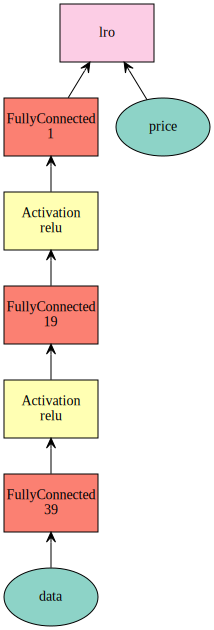

In [83]:
mx.random.seed(random_seed)
model_ctx = mx.cpu()
cols_layer = trainSelX.shape[1]
batch_size = 16 #16 # 64, 
data = mx.sym.var('data')
price = mx.symbol.Variable('price')
## The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=cols_layer)
act1 = mx.sym.Activation(data=fc1, act_type="relu")
## The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden=cols_layer//2)
act2 = mx.sym.Activation(data=fc2, act_type="relu")
## The output layer
out_layer  = mx.sym.FullyConnected(data=act2, name='out_layer', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=out_layer, label=price, name="lro")
print("network constructed...")
mx.viz.plot_network(symbol=lro)


In [84]:
train_iter = mx.io.NDArrayIter(data = nd.array(trainX), label = nd.array(trainY), \
                             batch_size=batch_size, shuffle=True, label_name="price")
validate_iter = mx.io.NDArrayIter(data = nd.array(validateX), label = nd.array(validateY), \
                             batch_size=batch_size)

## reset train_iter to the beginning
train_iter.reset()
## create a module
mod = mx.mod.Module(symbol = lro,
                    context = model_ctx,
                    label_names = ["price"])
## fit the module
mod.fit(train_iter,
        eval_data = validate_iter, 
        optimizer = "adam",  
        optimizer_params = {'learning_rate':0.01}, # +/- 0.005 hyperparameter search
        #initializer = mx.init.Normal(0.01),
        initializer =  mx.init.Xavier(rnd_type="gaussian", factor_type="avg", magnitude=3),
        eval_metric = "rmse",
        batch_end_callback = mx.callback.Speedometer(batch_size, 12000),
        num_epoch = 5
       )
       

INFO:root:Epoch[0] Batch [12000]	Speed: 15855.58 samples/sec	rmse=0.181879
INFO:root:Epoch[0] Batch [24000]	Speed: 16217.64 samples/sec	rmse=0.179198
INFO:root:Epoch[0] Batch [36000]	Speed: 15548.33 samples/sec	rmse=0.178422
INFO:root:Epoch[0] Batch [48000]	Speed: 15791.77 samples/sec	rmse=0.177580
INFO:root:Epoch[0] Batch [60000]	Speed: 16071.77 samples/sec	rmse=0.177516
INFO:root:Epoch[0] Batch [72000]	Speed: 15734.97 samples/sec	rmse=0.176900
INFO:root:Epoch[0] Batch [84000]	Speed: 15540.25 samples/sec	rmse=0.177103
INFO:root:Epoch[0] Train-rmse=0.177148
INFO:root:Epoch[0] Time cost=92.301
INFO:root:Epoch[0] Validation-rmse=0.178545
INFO:root:Epoch[1] Batch [12000]	Speed: 13747.39 samples/sec	rmse=0.177485
INFO:root:Epoch[1] Batch [24000]	Speed: 10856.23 samples/sec	rmse=0.177468
INFO:root:Epoch[1] Batch [36000]	Speed: 9206.62 samples/sec	rmse=0.177300
INFO:root:Epoch[1] Batch [48000]	Speed: 10621.87 samples/sec	rmse=0.176967
INFO:root:Epoch[1] Batch [60000]	Speed: 12595.93 samples/

## evaluate

In [85]:
test_iter = mx.io.NDArrayIter(data = nd.array(testX), label = nd.array(testY), \
                             batch_size=batch_size)
score = mod.score(test_iter, ['rmse'])
print("testX rmse:", score[0][1])

## testX rmse: 0.175563534173 => 1st layer (# cols), 2nd layer (# cols // 2)
## testX rmse: 0.176076898402 => 1st layer (# cols), 2nd layer (# cols // 3)
## testX rmse: 0.177890765419 => 1st layer (# cols), 2nd layer (# cols // 2), 3rd layer (# cols // 3)
## testX rmse: 0.178714017081 => 1st layer (# cols), 2nd layer (# cols)
## testX rmse: 0.179782506267 => 1st layer (# cols // 2)
## testX rmse: 0.183045320454 => 1st layer (# cols)

testX rmse: 0.180904642591
